In [1]:
!pip install transformers

In [2]:

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys   

In [3]:
train_path = "/kaggle/input/data-capec-multilabel/capec_mutilabel_new.csv"
test_path = "/kaggle/input/data-capec-multilabel/capec_mutilabel_new.csv"

In [4]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,accuracy_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

/tmp/ipykernel_26/897552558.py:1: DtypeWarning: Columns (5,6,22) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path)
/tmp/ipykernel_26/897552558.py:2: DtypeWarning: Columns (5,6,22) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_path)


In [6]:
train_df.drop(train_df.columns[1:24], axis=1, inplace=True)

In [7]:
df2 = train_df.loc[90000:624245]
df2 = df2.loc[(df2['242 - Code Injection'] == 1) 
              | (df2['16 - Dictionary-based Password Attack']==1)
              | (df2['153 - Input Data Manipulation']==1)
              | (df2['248 - Command Injection']==1)
              | (df2['34 - HTTP Response Splitting']==1)
              | (df2['274 - HTTP Verb Tampering'] == 1)
              | (df2['33 - HTTP Request Smuggling']==1)]

In [8]:
train_df = pd.concat([train_df.head(90000), df2], ignore_index=True)

In [9]:
target_list = ["000 - Normal", "272 - Protocol Manipulation", "242 - Code Injection", 
               "88 - OS Command Injection", "126 - Path Traversal", "66 - SQL Injection",
               "16 - Dictionary-based Password Attack", "310 - Scanning for Vulnerable Software", 
               "153 - Input Data Manipulation", "248 - Command Injection", 
               "274 - HTTP Verb Tampering", "194 - Fake the Source of Data", 
               "34 - HTTP Response Splitting", "33 - HTTP Request Smuggling"]

In [10]:
len(target_list)

14

In [11]:
# hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05
num_class=14

In [12]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
from transformers import BertTokenizer, BertModel, BertTokenizerFast

In [13]:
secBertTokenizer = BertTokenizerFast.from_pretrained("jackaduma/SecBERT", do_lower_case=True)
secBertModel = BertModel.from_pretrained("jackaduma/SecBERT", num_labels = num_class)

In [14]:
tokenizer = AutoTokenizer.from_pretrained('jackaduma/SecBERT')

In [15]:
def freeze_k_layer(secBert, k=1):
    for param in secBert.encoder.layer[0:k].parameters():
        param.requires_grad = False

In [16]:
freeze_k_layer(secBertModel, k=6)

In [17]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [18]:
train_size = 0.8
train_df1 = train_df.sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = train_df.drop(train_df1.index).reset_index(drop=True)

In [19]:
print(len(val_df))

26851


In [20]:
train_dataset = CustomDataset(train_df1, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [21]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [23]:
class Branch(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, dropout, num_outputs):
        super(Branch, self).__init__()

        self.dense1 = nn.Linear(input_size, hidden1_size)
        self.dropout = nn.Dropout(p=dropout)
        self.dense2 = nn.Linear(hidden1_size, hidden2_size)
        self.dense3 = nn.Linear(hidden2_size, num_outputs)

    def forward(self, x):
        out_dense1 = self.dense1(x)
        out_dropout = self.dropout(out_dense1)
        out_dense2 = self.dense2(out_dropout)
        out_dense3 = self.dense3(out_dense2)

        return out_dense3

In [24]:
class BaseModel(nn.Module):
    def __init__(self, original_model, num_classes):
        super(BaseModel, self).__init__()
        self.num_classes = num_classes
        self.original_model = original_model
        self.branches = nn.ModuleList([Branch(768, 128, 64, 0.1, 2) for _ in range(num_classes)])
        self.activation = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        out_bert = self.original_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooler_out = out_bert.pooler_output
        output_branches = [branch(pooler_out) for branch in self.branches]
        # outputs = [self.activation(out_branch) for out_branch in output_branches]

        # apply softmax function for each branch
        out_soft = [self.activation(out) for out in output_branches]
        out_soft_max_indices = [torch.argmax(out, dim=1) for out in out_soft]
        out_soft_max_indices = torch.stack(out_soft_max_indices, dim=1)

        return out_soft, out_soft_max_indices

secBertClassifierMultilabel = BaseModel(original_model=secBertModel, num_classes=num_class)

In [25]:
secBertClassifierMultilabel

BaseModel(
  (original_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [26]:
model = secBertClassifierMultilabel
model.to(device)
for step, batch in enumerate(train_data_loader):
        # push the batch to gpu
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        preds, max_indices = model(ids, attention_mask=mask, token_type_ids=token_type_ids)
        print(targets)
        print('--------')
        print(max_indices)
        break

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 

In [27]:
def calculate_score(y_true, preds, score_type=''):
    acc_score = 0.0
    if score_type=='multioutput':
        num_acc = 0
        for i in range(len(y_true)):
            if np.array_equal(y_true[i], preds[i]):
                num_acc+=1
        if len(y_true) != 0:
            acc_score = num_acc / len(y_true)
        else:
            acc_score = 0
    else:
        acc_score = accuracy_score(y_true, preds)

    return acc_score

In [28]:
def train_steps(training_loader, model, loss_f, optimizer, score_type=''):
    print('Training...')
    training_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    train_acc = 0.
    train_f1 = 0.
    misclassify_train_data = {}

    model.train()

    for step, batch in enumerate(training_loader):
        # push the batch to gpu
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        preds, max_indices = model(ids, attention_mask=mask, token_type_ids=token_type_ids)

        # calculate the loss for each branch
        losses = [loss_f(preds[i], targets[:, i]) for i in range(targets.shape[1])]
        average_loss = sum(losses) / targets.shape[1]
        training_loss += average_loss.item()

        label_ids = targets.to('cpu').numpy()
        max_indices = max_indices.detach().cpu().numpy()
        acc_score = calculate_score(label_ids, max_indices, score_type)
        train_acc += acc_score

#         if is_find_miss:
#             misclassify_data = get_misclassified_data(label_ids, max_indices, indices)
#             misclassify_train_data.update(misclassify_data)

        nb_tr_steps += 1

        optimizer.zero_grad()
        average_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # When using GPU
        optimizer.step()

    epoch_loss = training_loss / nb_tr_steps
    epoch_acc = train_acc / nb_tr_steps

    return epoch_loss, epoch_acc, misclassify_train_data

In [29]:
def evaluate_steps(validating_loader, model, loss_f, score_type='', **kwargs):
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step, batch in enumerate(validating_loader):
        # push the batch to gpu
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds, max_indices = model(ids, attention_mask=mask, token_type_ids=token_type_ids)

            # compute the validation loss between actual and predicted values
            losses = [loss_f(preds[i], targets[:, i]) for i in range(targets.shape[1])]
            average_loss = sum(losses) / targets.shape[1]
            total_loss += average_loss.item()

            max_indices = max_indices.detach().cpu().numpy()
            total_preds += list(max_indices)
            total_labels += targets.tolist()
    # compute the validation loss of the epoch
    if len(validating_loader) != 0:
        avg_loss = total_loss / len(validating_loader)
    else:
        avg_loss = 0
    acc_score = calculate_score(total_labels, total_preds, score_type)

    return avg_loss, acc_score

In [30]:
def train(epochs, model, optimizer, criterion, dataloader, score_type='multioutput', save_dir='/kaggle/working/', is_find_miss=True):
    data_train_loader, data_val_loader = dataloader
    # set initial loss to infinite
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    misclassify_train_data = {}

    for epoch in range(epochs):
        print('Epoch {}/{} '.format(epoch + 1, epochs))
        start_time = time.time()
        train_loss, train_acc, misclassify_train_steps_data = train_steps(data_train_loader, model, criterion, optimizer, score_type=score_type)
        valid_loss, valid_acc = evaluate_steps(data_val_loader, model, criterion, score_type=score_type)

    # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
#             torch.save(model.state_dict(), save_dir)
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        misclassify_train_data.update(misclassify_train_steps_data)

        elapsed_time = time.time() - start_time

        print('\t loss={:.4f} \t accuracy={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(train_loss, train_acc, valid_loss, valid_acc, elapsed_time))

    return train_accuracies, valid_accuracies, train_losses, valid_losses, misclassify_train_data

**Train SecBert-Escort model**

In [31]:
import time
import matplotlib.pyplot as plt

In [32]:
def plot_graph(epochs, train, valid, tittle):
    fig = plt.figure(figsize=(12,12))
    plt.title(tittle)
    plt.plot(list(np.arange(epochs) + 1) , train, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

Epoch 1/10 
Training...

Evaluating...
	 loss=0.3732 	 accuracy=0.3156 	 val_loss=0.3945  	 val_acc=0.0000  	 time=1906.63s
Epoch 2/10 
Training...

Evaluating...
	 loss=0.3511 	 accuracy=0.5486 	 val_loss=0.3947  	 val_acc=0.0000  	 time=1916.09s
Epoch 3/10 
Training...

Evaluating...
	 loss=0.3481 	 accuracy=0.5865 	 val_loss=0.3946  	 val_acc=0.0000  	 time=1915.24s
Epoch 4/10 
Training...

Evaluating...
	 loss=0.3479 	 accuracy=0.5870 	 val_loss=0.3945  	 val_acc=0.0000  	 time=1914.78s
Epoch 5/10 
Training...

Evaluating...
	 loss=0.3478 	 accuracy=0.5876 	 val_loss=0.3946  	 val_acc=0.0000  	 time=1914.82s
Epoch 6/10 
Training...

Evaluating...
	 loss=0.3478 	 accuracy=0.5880 	 val_loss=0.3945  	 val_acc=0.0000  	 time=1914.14s
Epoch 7/10 
Training...

Evaluating...
	 loss=0.3478 	 accuracy=0.5886 	 val_loss=0.3947  	 val_acc=0.0000  	 time=1913.37s
Epoch 8/10 
Training...

Evaluating...
	 loss=0.3477 	 accuracy=0.5886 	 val_loss=0.3947  	 val_acc=0.0000  	 time=1912.47s
Epoch 9/

'\nEvaluate model on test set and save the result\n'

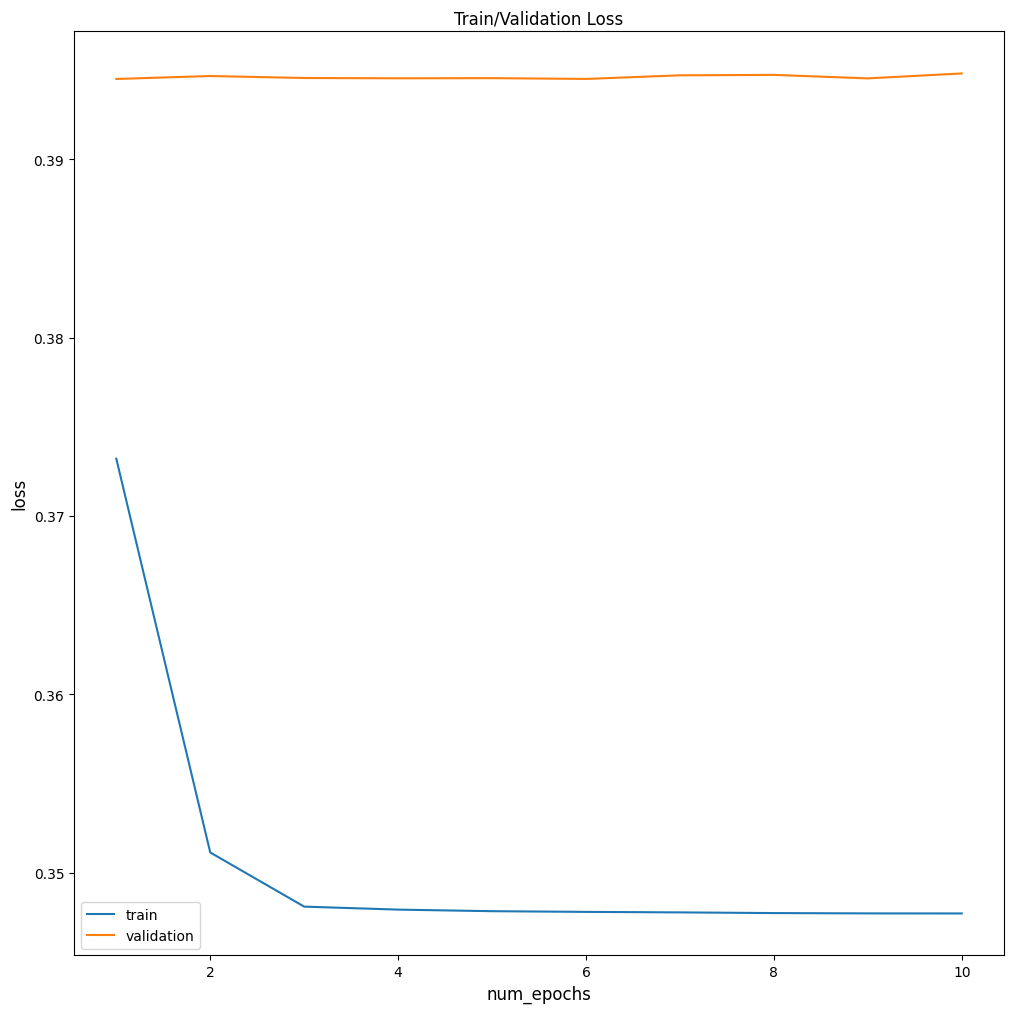

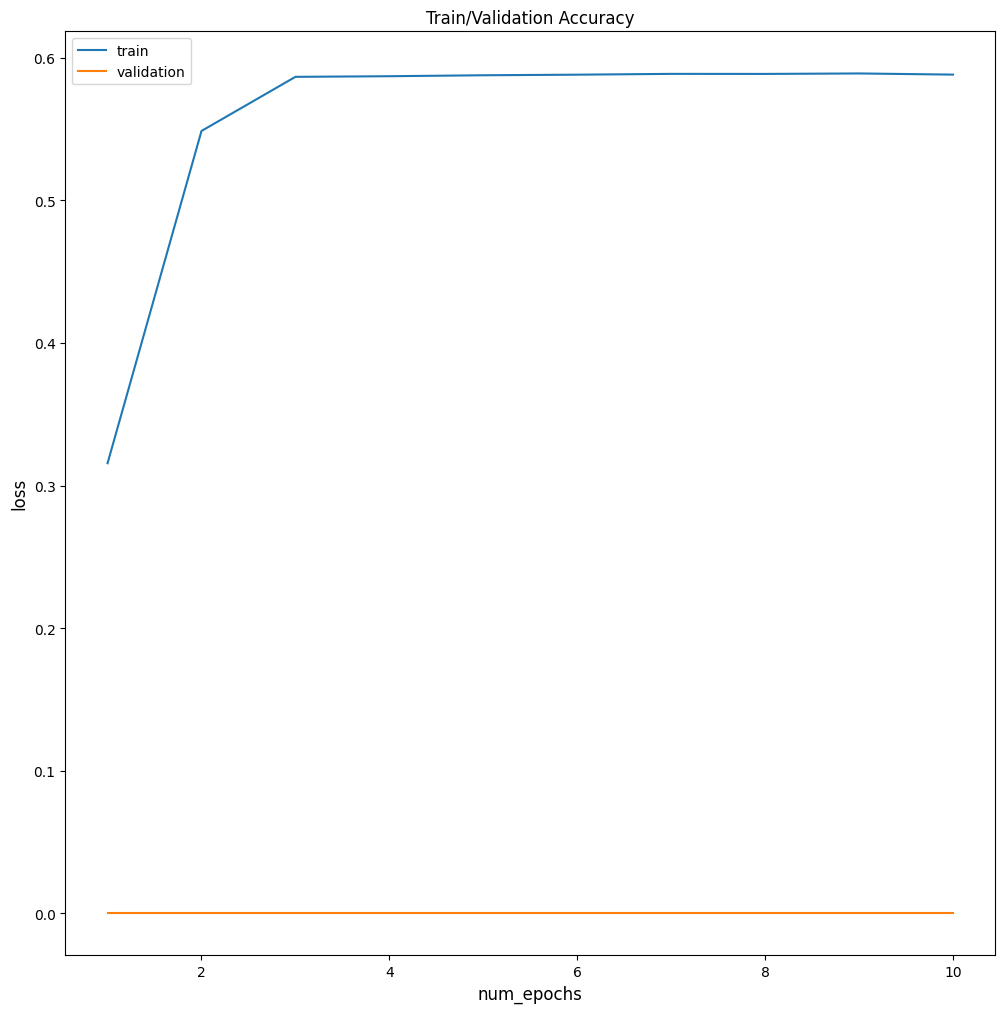

In [33]:
secBertClassifierMultilabel.to(device)

# Creating the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = secBertClassifierMultilabel.parameters(), lr=LEARNING_RATE)

train_accuracies, valid_accuracies, train_losses, valid_losses, misclassify_train_data = train(EPOCHS, secBertClassifierMultilabel, optimizer, criterion, (train_data_loader, val_data_loader))
# df = pd.DataFrame.from_dict(misclassify_train_data, orient='index', columns=labels)
# df.index.name = 'X_train_index'
# df.to_csv(data_folder+'misclassified-data.csv')

"""
Plot the result of training process
"""
plot_graph(EPOCHS, train_losses, valid_losses, "Train/Validation Loss")
plot_graph(EPOCHS, train_accuracies, valid_accuracies, "Train/Validation Accuracy")

"""
Evaluate model on test set and save the result
"""
# total_labels, total_preds = predict(testing_loader, secBertClassifierMultilabel)
# df_labels = pd.DataFrame(total_labels, columns=labels)
# df_preds = pd.DataFrame(total_preds, columns=labels)

# df_labels.to_csv(data_folder+'labels-test-secbert-escort.csv')
# df_preds.to_csv(data_folder+'preds-secbert-escort.csv')

# save_classification(y_test=np.array(total_labels), y_pred=np.array(total_preds), labels=labels, out_dir='escort-secbert.csv')

In [34]:
from sklearn.metrics import hamming_loss

In [35]:
def save_classification(y_test, y_pred, labels):
    if isinstance(y_pred, np.ndarray) == False:
        y_pred = y_pred.toarray()

    def accuracy(y_true, y_pred):
        temp = 0
        for i in range(y_true.shape[0]):
            numerator = sum(np.logical_and(y_true[i], y_pred[i]))
            denominator = sum(np.logical_or(y_true[i], y_pred[i]))
            if denominator != 0:
                temp += numerator / denominator
        return temp / y_true.shape[0]

    out = classification_report(y_test,y_pred, output_dict=True, target_names=labels)
    total_support = out['samples avg']['support']

    mr = accuracy_score(y_test, y_pred)
    acc = accuracy(y_test,y_pred)
    hm = hamming_loss(y_test, y_pred)

    out['Exact Match Ratio'] = {'precision': mr, 'recall': mr, 'f1-score': mr, 'support': total_support}
    out['Hamming Loss'] = {'precision': hm, 'recall': hm, 'f1-score': hm, 'support': total_support}
    out['Accuracy'] = {'precision': acc, 'recall': acc, 'f1-score': acc, 'support': total_support}
    out_df = pd.DataFrame(out).transpose()
    print(out_df)

    

    return out_df

In [36]:
def predict(testing_loader, model):
    print("\nPredicting...")
    # deactivate dropout layers
    model.eval()

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step, batch in enumerate(testing_loader):
        # push the batch to gpu
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].to(device)

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds, max_indices = model(ids, attention_mask=mask, token_type_ids=token_type_ids)

            max_indices = max_indices.detach().cpu().numpy()
            total_preds += list(max_indices)
            total_labels += targets.tolist()

    return total_labels, total_preds

In [37]:
total_labels, total_preds = predict(train_data_loader, secBertClassifierMultilabel)
save_classification(y_test=np.array(total_labels), y_pred=np.array(total_preds), labels=target_list)


Predicting...


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score  \
000 - Normal                             0.932923  0.970543  0.951362   
272 - Protocol Manipulation              0.000000  0.000000  0.000000   
242 - Code Injection                     0.000000  0.000000  0.000000   
88 - OS Command Injection                0.000000  0.000000  0.000000   
126 - Path Traversal                     0.987846  0.848700  0.913002   
66 - SQL Injection                       0.000000  0.000000  0.000000   
16 - Dictionary-based Password Attack    0.000000  0.000000  0.000000   
310 - Scanning for Vulnerable Software   0.000000  0.000000  0.000000   
153 - Input Data Manipulation            0.000000  0.000000  0.000000   
248 - Command Injection                  0.000000  0.000000  0.000000   
274 - HTTP Verb Tampering                0.000000  0.000000  0.000000   
194 - Fake the Source of Data            0.999475  0.917304  0.956628   
34 - HTTP Response Splitting             0.000000  

,precision,recall,f1-score,support
000 - Normal,0.932923,0.970543,0.951362,19690.0
272 - Protocol Manipulation,0.000000,0.000000,0.000000,1914.0
242 - Code Injection,0.000000,0.000000,0.000000,12585.0
88 - OS Command Injection,0.000000,0.000000,0.000000,1856.0
126 - Path Traversal,0.987846,0.848700,0.913002,14078.0
66 - SQL Injection,0.000000,0.000000,0.000000,1726.0
16 - Dictionary-based Password Attack,0.000000,0.000000,0.000000,1472.0
310 - Scanning for Vulnerable Software,0.000000,0.000000,0.000000,2157.0
153 - Input Data Manipulation,0.000000,0.000000,0.000000,1821.0
248 - Command Injection,0.000000,0.000000,0.000000,0.0
